# Variance Reduction Unleashed: A Monte Carlo Journey to Accurate Option Pricing

## Introduction

This project demonstrates how to price a European call option using Monte Carlo simulation techniques. Three different Monte Carlo methods are implemented:

1. **Simple Monte Carlo**
2. **Antithetic Variates**
3. **Control Variates**

In addition to pricing, the project includes:
- **Convergence Analysis:** Visualizing the cumulative average of discounted payoffs using 1,000 simulation paths for each method.
- **Stock Price Path Simulation:** Simulating full asset paths over one year (252 trading days) to observe the evolution of the underlying stock.

## Theoretical Background

### Black-Scholes Model

The theoretical price of a European call option is given by the Black-Scholes formula:

$$
C = S_0 \, N(d_1) - K \, e^{-rT} \, N(d_2)
$$

where

$$
d_1 = \frac{\ln(S_0/K) + \left(r + \frac{1}{2}\sigma^2\right)T}{\sigma\sqrt{T}}, \quad
d_2 = d_1 - \sigma\sqrt{T}
$$

- $S_0$: Initial stock price  
- $K$: Strike price  
- $T$: Time to maturity (years)  
- $r$: Risk-free interest rate  
- $\sigma$: Volatility  
- $N(\cdot)$: Cumulative distribution function (CDF) of the standard normal distribution

### Monte Carlo Simulation for Option Pricing

The underlying asset price is modeled using geometric Brownian motion:

$$
S_T = S_0 \exp\left[\left(r - \frac{1}{2}\sigma^2\right)T + \sigma\sqrt{T} \, Z\right]
$$

with $Z \sim N(0,1)$. The discounted payoff of a European call option is:

$$
\text{Payoff} = e^{-rT} \max(S_T - K, 0)
$$

The Monte Carlo estimator for the option price is the average of these discounted payoffs across many simulated paths.

### Variance Reduction Techniques

Monte Carlo simulation can suffer from high variance, making convergence slow. Two common variance reduction techniques are used:

1. **Antithetic Variates:**  
   For each random sample $Z$, its negative $-Z$ is also used. This produces paired estimates that tend to cancel out some of the random noise:
   
   $$
   \text{Payoff}_{\text{antithetic}} = \frac{1}{2}\left[\max\left(S_T(Z) - K, 0\right) + \max\left(S_T(-Z) - K, 0\right)\right]
   $$

2. **Control Variates:**  
   A control variate with a known expected value is used to adjust the payoff. In this project, the terminal stock price $S_T$, which has an expected value of $S_0 e^{rT}$, is used. The adjusted payoff is:
   
   $$
   \text{Payoff}_{\text{adjusted}} = \text{Payoff} - c \left(S_T - S_0 e^{rT}\right)
   $$
   
   where $c$ is an optimal coefficient computed based on the covariance between the payoff and $S_T$.

### Stock Price Path Simulation

To simulate full asset paths over a one-year period (with 252 trading days), the following discrete-time approximation of geometric Brownian motion is used:

$$
S_{t+\Delta t} = S_t \exp\left[\left(r - \frac{1}{2}\sigma^2\right)\Delta t + \sigma\sqrt{\Delta t} \, Z\right]
$$

with $\Delta t = \frac{T}{252}$ and $Z \sim N(0,1)$.

## Project Structure

- **Price Calculation:**  
  The Black-Scholes formula is used for the theoretical price, while the three Monte Carlo methods (Simple, Antithetic, and Control Variate) are implemented with 100,000 simulation paths for high accuracy.

- **Convergence Analysis:**  
  For each Monte Carlo method, the cumulative average of the discounted payoffs is computed using 1,000 simulation paths. These convergence plots help visualize how quickly the estimator stabilizes.

- **Stock Price Simulation:**  
  Full stock price paths are simulated over one year (252 trading days) for each Monte Carlo method. This provides insight into the dynamics of the underlying asset.

## Conclusion

This project illustrates the practical implementation of Monte Carlo simulation methods for option pricing, highlighting the use of variance reduction techniques to improve efficiency. The convergence plots and stock price path simulations offer valuable visual insights into both the estimation process and the behavior of the underlying asset over time.

*Prepared by: Amit Kumar Jha*

*Date: 2025-02-09*


Black-Scholes Price: 10.4506

Monte Carlo Results (100,000 sims):
Simple MC:          Price: 10.4739 	Std Error: 0.0466
Antithetic MC:      Price: 10.4611 	Std Error: 0.0233
Control Variate MC: Price: 10.4586 	Std Error: 0.0177


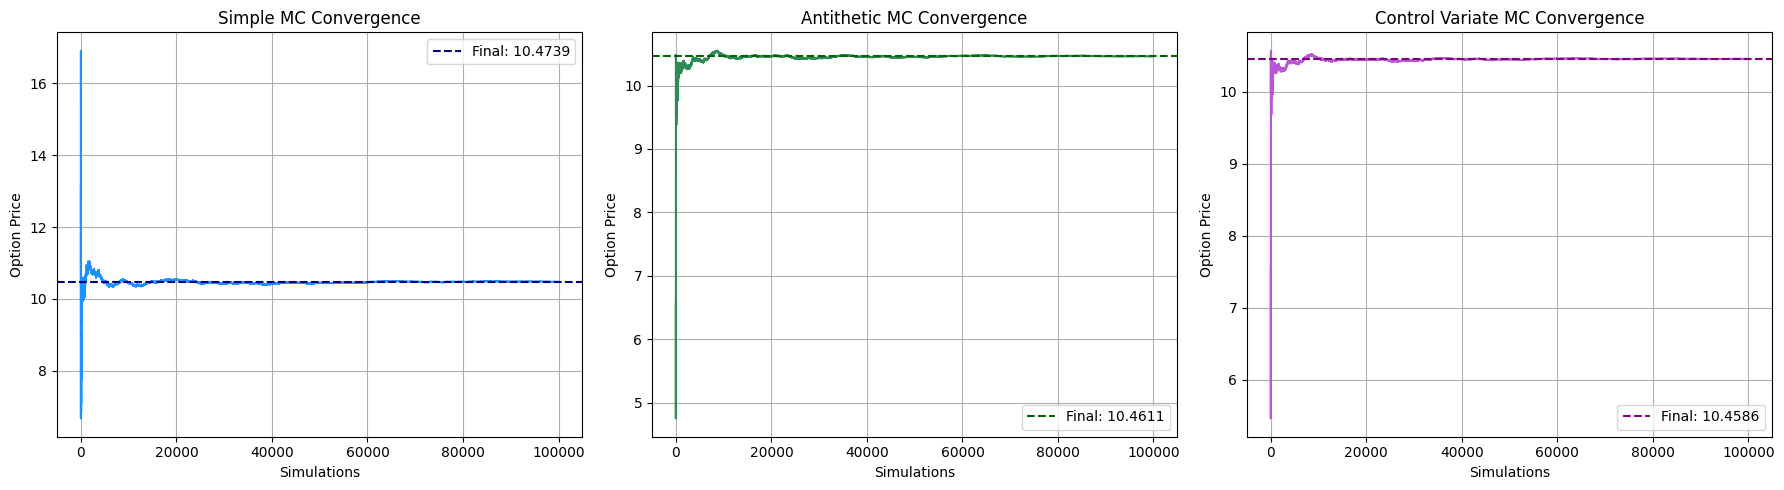

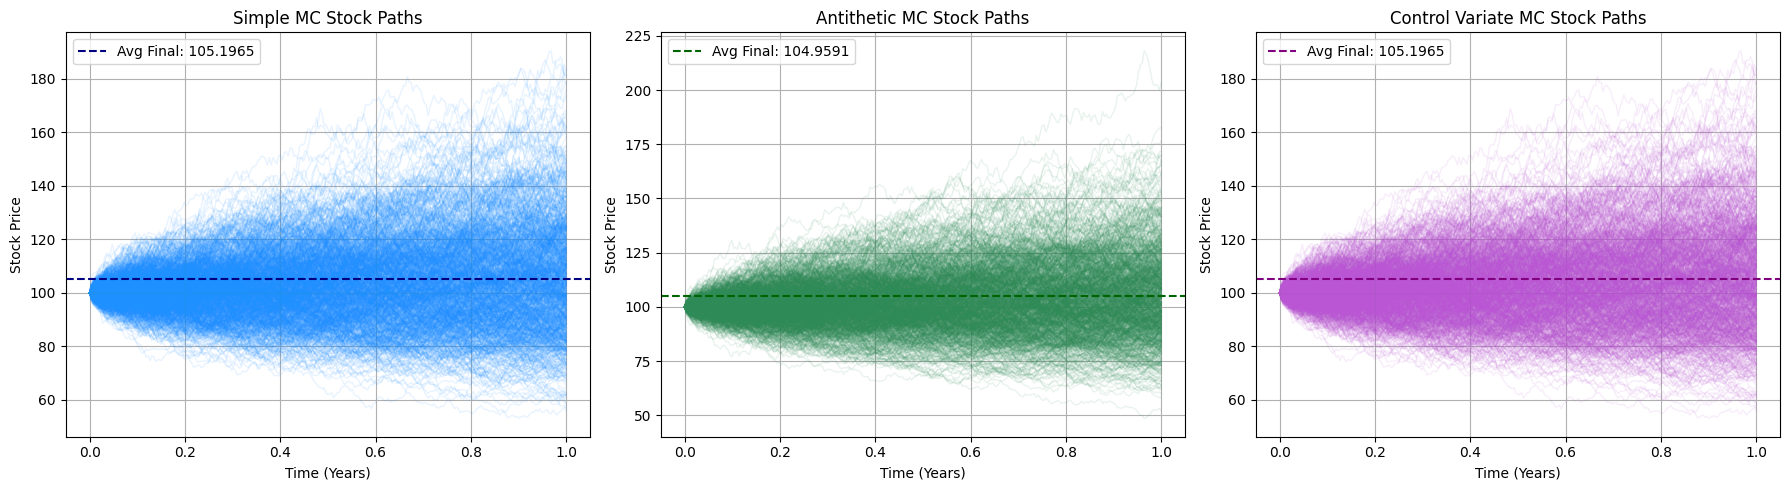

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.stats import norm

# -------------------------------------------------
# Option Definition and Black-Scholes Formula
# -------------------------------------------------
@dataclass
class EuropeanCallOption:
    S0: float    # Initial stock price
    K: float     # Strike price
    T: float     # Time to maturity (in years)
    r: float     # Risk-free rate
    sigma: float # Volatility

def black_scholes_call(option: EuropeanCallOption) -> float:
    """
    Black-Scholes formula for a European Call option.

    d1 = [ln(S0/K) + (r + 0.5*sigma^2)*T] / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)

    Price = S0*N(d1) - K*exp(-r*T)*N(d2)
    """
    d1 = (np.log(option.S0 / option.K) + (option.r + 0.5 * option.sigma**2) * option.T) / (option.sigma * np.sqrt(option.T))
    d2 = d1 - option.sigma * np.sqrt(option.T)
    return option.S0 * norm.cdf(d1) - option.K * np.exp(-option.r * option.T) * norm.cdf(d2)

# -------------------------------------------------
# Monte Carlo Pricing Methods (100,000 simulations for accurate estimates)
# -------------------------------------------------
def simple_mc(option: EuropeanCallOption, num_sims: int) -> tuple:
    """
    Simple Monte Carlo simulation for a European Call option.
    """
    np.random.seed(42)
    Z = np.random.normal(size=num_sims)
    ST = option.S0 * np.exp((option.r - 0.5 * option.sigma**2) * option.T +
                              option.sigma * np.sqrt(option.T) * Z)
    payoff = np.maximum(ST - option.K, 0)
    discount_factor = np.exp(-option.r * option.T)
    price = discount_factor * np.mean(payoff)
    stderr = discount_factor * np.std(payoff) / np.sqrt(num_sims)
    return price, stderr

def antithetic_mc(option: EuropeanCallOption, num_sims: int) -> tuple:
    """
    Monte Carlo simulation using antithetic variates.
    """
    np.random.seed(42)
    Z = np.random.normal(size=num_sims)
    ST1 = option.S0 * np.exp((option.r - 0.5 * option.sigma**2) * option.T +
                              option.sigma * np.sqrt(option.T) * Z)
    ST2 = option.S0 * np.exp((option.r - 0.5 * option.sigma**2) * option.T -
                              option.sigma * np.sqrt(option.T) * Z)
    payoff = 0.5 * (np.maximum(ST1 - option.K, 0) + np.maximum(ST2 - option.K, 0))
    discount_factor = np.exp(-option.r * option.T)
    price = discount_factor * np.mean(payoff)
    stderr = discount_factor * np.std(payoff) / np.sqrt(num_sims)
    return price, stderr

def control_variate_mc(option: EuropeanCallOption, num_sims: int) -> tuple:
    """
    Monte Carlo simulation with control variates using S_T as the control.

    Adjusted payoff = payoff - c*(S_T - E[S_T])
    where E[S_T] = S0 * exp(r*T)
    """
    np.random.seed(42)
    Z = np.random.normal(size=num_sims)
    ST = option.S0 * np.exp((option.r - 0.5 * option.sigma**2) * option.T +
                             option.sigma * np.sqrt(option.T) * Z)
    payoff = np.maximum(ST - option.K, 0)
    control_variate = ST
    EY = option.S0 * np.exp(option.r * option.T)
    cov = np.cov(payoff, control_variate)[0, 1]
    var_Y = np.var(control_variate)
    c = cov / var_Y
    adjusted_payoff = payoff - c * (control_variate - EY)
    discount_factor = np.exp(-option.r * option.T)
    price = discount_factor * np.mean(adjusted_payoff)
    stderr = discount_factor * np.std(adjusted_payoff) / np.sqrt(num_sims)
    return price, stderr

# -------------------------------------------------
# Functions for Convergence (Cumulative Average) Plots (using 1,000 simulations)
# -------------------------------------------------
def simple_mc_paths(option: EuropeanCallOption, num_sims: int) -> np.ndarray:
    np.random.seed(42)
    Z = np.random.normal(size=num_sims)
    ST = option.S0 * np.exp((option.r - 0.5 * option.sigma**2) * option.T +
                              option.sigma * np.sqrt(option.T) * Z)
    payoff = np.maximum(ST - option.K, 0)
    discount_factor = np.exp(-option.r * option.T)
    prices = discount_factor * payoff
    return np.cumsum(prices) / np.arange(1, num_sims + 1)

def antithetic_mc_paths(option: EuropeanCallOption, num_sims: int) -> np.ndarray:
    np.random.seed(42)
    Z = np.random.normal(size=num_sims)
    ST1 = option.S0 * np.exp((option.r - 0.5 * option.sigma**2) * option.T +
                              option.sigma * np.sqrt(option.T) * Z)
    ST2 = option.S0 * np.exp((option.r - 0.5 * option.sigma**2) * option.T -
                              option.sigma * np.sqrt(option.T) * Z)
    payoff = 0.5 * (np.maximum(ST1 - option.K, 0) + np.maximum(ST2 - option.K, 0))
    discount_factor = np.exp(-option.r * option.T)
    prices = discount_factor * payoff
    return np.cumsum(prices) / np.arange(1, num_sims + 1)

def control_variate_mc_paths(option: EuropeanCallOption, num_sims: int) -> np.ndarray:
    np.random.seed(42)
    Z = np.random.normal(size=num_sims)
    ST = option.S0 * np.exp((option.r - 0.5 * option.sigma**2) * option.T +
                             option.sigma * np.sqrt(option.T) * Z)
    payoff = np.maximum(ST - option.K, 0)
    control_variate = ST
    EY = option.S0 * np.exp(option.r * option.T)
    cov = np.cov(payoff, control_variate)[0, 1]
    var_Y = np.var(control_variate)
    c = cov / var_Y
    adjusted_payoff = payoff - c * (control_variate - EY)
    discount_factor = np.exp(-option.r * option.T)
    prices = discount_factor * adjusted_payoff
    return np.cumsum(prices) / np.arange(1, num_sims + 1)

# -------------------------------------------------
# Functions for Stock Price Path Simulation Over 1 Year (252 trading days)
# -------------------------------------------------
def simulate_stock_paths(option: EuropeanCallOption, num_paths: int, num_steps: int) -> np.ndarray:
    """
    Standard simulation for stock price paths using geometric Brownian motion.
    (Used for Simple and Control Variate MC.)
    """
    dt = option.T / num_steps
    S = np.zeros((num_paths, num_steps + 1))
    S[:, 0] = option.S0
    np.random.seed(42)
    for t in range(1, num_steps + 1):
        Z = np.random.normal(size=num_paths)
        S[:, t] = S[:, t-1] * np.exp((option.r - 0.5 * option.sigma**2) * dt + option.sigma * np.sqrt(dt) * Z)
    return S

def simulate_stock_paths_antithetic(option: EuropeanCallOption, num_paths: int, num_steps: int) -> np.ndarray:
    """
    Simulation for stock price paths using antithetic variates.
    Here, we generate num_paths/2 independent paths and use their antithetic counterparts.
    """
    dt = option.T / num_steps
    half_paths = num_paths // 2
    S = np.zeros((num_paths, num_steps + 1))
    S[:half_paths, 0] = option.S0
    S[half_paths:, 0] = option.S0
    np.random.seed(42)
    for t in range(1, num_steps + 1):
        Z = np.random.normal(size=half_paths)
        S[:half_paths, t] = S[:half_paths, t-1] * np.exp((option.r - 0.5 * option.sigma**2)*dt + option.sigma * np.sqrt(dt) * Z)
        S[half_paths:, t] = S[half_paths:, t-1] * np.exp((option.r - 0.5 * option.sigma**2)*dt + option.sigma * np.sqrt(dt) * (-Z))
    return S

# -------------------------------------------------
# Main Execution: Price Calculation and Plotting
# -------------------------------------------------
# Option parameters
option = EuropeanCallOption(S0=100, K=100, T=1, r=0.05, sigma=0.2)
num_sims = 100000  # High number for accurate price estimation

# Calculate MC prices using 100,000 simulations
bs_price = black_scholes_call(option)
simple_price, simple_err = simple_mc(option, num_sims)
antithetic_price, antithetic_err = antithetic_mc(option, num_sims)
control_price, control_err = control_variate_mc(option, num_sims)

print(f"Black-Scholes Price: {bs_price:.4f}\n")
print("Monte Carlo Results (100,000 sims):")
print(f"Simple MC:          Price: {simple_price:.4f} \tStd Error: {simple_err:.4f}")
print(f"Antithetic MC:      Price: {antithetic_price:.4f} \tStd Error: {antithetic_err:.4f}")
print(f"Control Variate MC: Price: {control_price:.4f} \tStd Error: {control_err:.4f}")

# -------------------------------
# Figure 1: Convergence Plots (using 1,000 simulation paths)
# -------------------------------
num_paths_plot = 100000

simple_conv = simple_mc_paths(option, num_paths_plot)
antithetic_conv = antithetic_mc_paths(option, num_paths_plot)
control_conv = control_variate_mc_paths(option, num_paths_plot)

fig1, ax1 = plt.subplots(1, 3, figsize=(18, 5))

# Simple MC Convergence
ax1[0].plot(np.arange(1, num_paths_plot + 1), simple_conv, color='dodgerblue', lw=1.5)
final_simple = simple_conv[-1]
ax1[0].axhline(final_simple, color='navy', linestyle='--', label=f"Final: {final_simple:.4f}")
ax1[0].set_title("Simple MC Convergence")
ax1[0].set_xlabel("Simulations")
ax1[0].set_ylabel("Option Price")
ax1[0].legend()
ax1[0].grid(True)

# Antithetic MC Convergence
ax1[1].plot(np.arange(1, num_paths_plot + 1), antithetic_conv, color='seagreen', lw=1.5)
final_antithetic = antithetic_conv[-1]
ax1[1].axhline(final_antithetic, color='darkgreen', linestyle='--', label=f"Final: {final_antithetic:.4f}")
ax1[1].set_title("Antithetic MC Convergence")
ax1[1].set_xlabel("Simulations")
ax1[1].set_ylabel("Option Price")
ax1[1].legend()
ax1[1].grid(True)

# Control Variate MC Convergence
ax1[2].plot(np.arange(1, num_paths_plot + 1), control_conv, color='mediumorchid', lw=1.5)
final_control = control_conv[-1]
ax1[2].axhline(final_control, color='purple', linestyle='--', label=f"Final: {final_control:.4f}")
ax1[2].set_title("Control Variate MC Convergence")
ax1[2].set_xlabel("Simulations")
ax1[2].set_ylabel("Option Price")
ax1[2].legend()
ax1[2].grid(True)

plt.tight_layout()
plt.show()

# -------------------------------
# Figure 2: Stock Price Simulation Plots for Each MC Method
# (Each subplot shows 1,000 simulated paths over 1 year (252 days))
# -------------------------------
num_paths_sim = 1000
num_steps = 252
time_grid = np.linspace(0, option.T, num_steps+1)

# Simple MC Simulation (standard simulation)
stock_paths_simple = simulate_stock_paths(option, num_paths_sim, num_steps)
avg_final_simple = np.mean(stock_paths_simple[:, -1])

# Antithetic MC Simulation
stock_paths_antithetic = simulate_stock_paths_antithetic(option, num_paths_sim, num_steps)
avg_final_antithetic = np.mean(stock_paths_antithetic[:, -1])

# Control Variate Simulation (same as simple simulation)
stock_paths_control = simulate_stock_paths(option, num_paths_sim, num_steps)
avg_final_control = np.mean(stock_paths_control[:, -1])

fig2, ax2 = plt.subplots(1, 3, figsize=(18, 5))

# Simple MC Stock Paths
for path in stock_paths_simple:
    ax2[0].plot(time_grid, path, color='dodgerblue', alpha=0.1, lw=1)
ax2[0].axhline(avg_final_simple, color='navy', linestyle='--', label=f"Avg Final: {avg_final_simple:.4f}")
ax2[0].set_title("Simple MC Stock Paths")
ax2[0].set_xlabel("Time (Years)")
ax2[0].set_ylabel("Stock Price")
ax2[0].legend()
ax2[0].grid(True)

# Antithetic MC Stock Paths
for path in stock_paths_antithetic:
    ax2[1].plot(time_grid, path, color='seagreen', alpha=0.1, lw=1)
ax2[1].axhline(avg_final_antithetic, color='darkgreen', linestyle='--', label=f"Avg Final: {avg_final_antithetic:.4f}")
ax2[1].set_title("Antithetic MC Stock Paths")
ax2[1].set_xlabel("Time (Years)")
ax2[1].set_ylabel("Stock Price")
ax2[1].legend()
ax2[1].grid(True)

# Control Variate MC Stock Paths
for path in stock_paths_control:
    ax2[2].plot(time_grid, path, color='mediumorchid', alpha=0.1, lw=1)
ax2[2].axhline(avg_final_control, color='purple', linestyle='--', label=f"Avg Final: {avg_final_control:.4f}")
ax2[2].set_title("Control Variate MC Stock Paths")
ax2[2].set_xlabel("Time (Years)")
ax2[2].set_ylabel("Stock Price")
ax2[2].legend()
ax2[2].grid(True)

plt.tight_layout()
plt.show()


# Results Interpretation for Monte Carlo Option Pricing

## Overview

The simulation results for the European call option pricing are summarized as follows:

- **Black-Scholes Price:** $10.4506$
- **Monte Carlo Results (100,000 simulations):**
  - **Simple MC:** Price = $10.4739$, Std Error = $0.0466$
  - **Antithetic MC:** Price = $10.4611$, Std Error = $0.0233$
  - **Control Variate MC:** Price = $10.4586$, Std Error = $0.0177$

In this section, we interpret these results and discuss the efficiency of the different Monte Carlo methods.

## Detailed Interpretation

### 1. Comparison with the Black-Scholes Price

The Black-Scholes formula provides the theoretical price of a European call option. In our simulation, the Black-Scholes price is given by:

$$
C_{\text{BS}} = 10.4506
$$

All three Monte Carlo methods produce estimates that are very close to the theoretical value:

- **Simple MC:** $10.4739$
- **Antithetic MC:** $10.4611$
- **Control Variate MC:** $10.4586$

This close agreement indicates that the Monte Carlo estimators are unbiased and converge to the true price as the number of simulations increases.

### 2. Variance and Efficiency

The efficiency of a Monte Carlo estimator is often measured by its standard error. The standard error generally scales as:

$$
\text{Std Error} \propto \frac{1}{\sqrt{N}},
$$

where $N$ is the number of simulations. A lower standard error implies a more precise estimate.

- **Simple Monte Carlo:**  
  Standard error = $0.0466$.  
  This method uses basic random sampling without any variance reduction techniques.

- **Antithetic Variates:**  
  Standard error = $0.0233$.  
  By pairing each random sample $Z$ with its antithetic counterpart $-Z$, this method effectively cancels out some of the random noise. The antithetic estimator is given by:

  $$
  \hat{C}_{\text{antithetic}} = \frac{1}{2}\Big(\hat{C}(Z) + \hat{C}(-Z)\Big)
  $$

- **Control Variates:**  
  Standard error = $0.0177$.  
  This method uses the known expected value of the terminal stock price, $\mathbb{E}[S_T] = S_0 e^{rT}$, as a control variable to adjust the payoff:

  $$
  \hat{C}_{\text{control}} = \hat{C} - c\Big(S_T - S_0 e^{rT}\Big)
  $$

  The coefficient $c$ is chosen to minimize the variance of the estimator. This method achieves the smallest standard error, indicating that it is the most efficient among the three.

### 3. Mathematical Insight

For a Monte Carlo estimator $\hat{C}$, the standard error is approximately:

$$
\text{Std Error} \approx \frac{\sigma_{\hat{C}}}{\sqrt{N}},
$$

where $\sigma_{\hat{C}}$ is the standard deviation of the estimator. The variance reduction techniques help reduce $\sigma_{\hat{C}}$, leading to a lower standard error even if $N$ remains constant.

## Conclusion

- **Accuracy:** All three Monte Carlo methods converge to the theoretical Black-Scholes price of $10.4506$, which confirms the unbiased nature of these estimators.
- **Efficiency:**  
  - The **Simple MC** method yields a higher standard error ($0.0466$).  
  - The **Antithetic MC** method reduces the standard error to $0.0233$ by exploiting negative correlation between paired samples.  
  - The **Control Variate MC** method achieves the best performance with a standard error of $0.0177$, making it the most efficient method in this simulation.

The results highlight the importance of variance reduction techniques in Monte Carlo simulations, particularly in financial applications where precise option pricing is critical.
